In [1]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
import api as pyq 
import importlib
import os
import h5py
import pandas as pd
import pdb
import pyscf
import numpy as np
import pyqmc
import scipy
from pyscf.scf.hf import dump_scf_summary
from concurrent.futures import ProcessPoolExecutor
from pyscf.scf.chkfile import dump_scf
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/__init__.py


In [2]:
# !pip install pyqmc

In [54]:
# H2 molecule
def run_scf(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.;H 0. 0. 1.;", basis=f'ccecpccpvdz', unit='bohr')
    mf = scf.UHF(mol)
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm)
    dump_scf(mf.mol, 'scf.hdf5', mf.energy_tot(), mf.mo_energy, mf.mo_coeff, mf.mo_occ)
    return mf

def run_lda_be(scf_checkfile):
    print("Be atom neutral LDA spin=2")
    mol = gto.M(atom="Be 0. 0. 0.", spin=2,basis=f'ccpvdz', unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")        
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_li(scf_checkfile):
    print("Li atom neutral LDA spin=1")
    mol = gto.M(atom="Li 0. 0. 0.",basis=f'ccpvtz', spin=1, unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_he(scf_checkfile):
    print("He atom neutral LDA spin=0")
    # mol = gto.M(atom="He 0. 0. 0.", basis="ccECP_cc-pVDZ", ecp="ccecp", unit='bohr')
    mol = gto.M(atom="He 0. 0. 0.", basis="ccpvdz", unit='bohr')    
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_h2(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.; H 0. 0. 2", spin = 2, basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.xc='LDA, VWN'
    mf.kernel()    
    # mf.kernel(dm, xc='LDA,VWN')
    return mf

def run_lda(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.", spin=1,basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf
    
def run_casscf(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    mc = mcscf.CASSCF(mf,2,2)
    mc.chkfile = ci_checkfile
    mc.kernel()
    with h5py.File(mc.chkfile, "a") as f:
        print("Available output from CASSCF:", f["mcscf"].keys())
        f["mcscf/nelecas"] = list(mc.nelecas)
        f["mcscf/ci"] = mc.ci
    return mc

def run_casci(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    # ncas: orbitals
    # nelecas: electrons
    ncas = 4
    nelecas = 2
    mc = mcscf.CASCI(mf, ncas, nelecas)
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff
        print("Available output from CASCI:", f["ci"].keys())
    return mc

def make_wf_object(scf_checkfile, ci_checkfile):
    mol, mf, mc = pyq.recover_pyscf(scf_checkfile, ci_checkfile=ci_checkfile)
    wf, _ = pyq.generate_wf(mol, mf, mc=mc)
    return wf

def stat_qmc(etot, filename):
    block_sizes = np.linspace(2,len(etot[discard:])//16, 10, dtype=int)
    reblocks = [len(etot)//s for s in block_sizes]

    plt.figure()
    df = pd.DataFrame([pyq.read_mc_output(filename, warmup=discard, reblock=reblock) for reblock in reblocks])
    df['block_size'] = block_sizes
    plt.plot("block_size",'energytotal_err',data=df, marker='o')
    plt.xlabel("Block size")
    plt.ylabel("Estimated uncertainty (Ha)")

def reblock(e, discard, reblock_size):
    e = e[discard:]
    vals = pyqmc.reblock.reblock(e,int(len(e)/reblock_size))
    # import pdb
    # pdb.set_trace()
    
    e_m  = np.mean(vals, axis=0)
    e_d  = scipy.stats.sem(vals, axis=0)    
    return e, e_m, e_d

scf_checkfile = "scf.hdf5"
ci_checkfile = "ci.hdf5"
# mf = run_scf(scf_checkfile)
mf_lda = run_lda(scf_checkfile)

# mc = run_casci(scf_checkfile, ci_checkfile)

converged SCF energy = -0.856973623578646  <S^2> = 2  2S+1 = 3


In [51]:
tstep = 0.001
nconfig = 2000
nsteps = 10000
discard = 100
reblock_size = 50

In [5]:
from recipes import ABOPTIMIZE, OPTIMIZE
import importlib, recipes
modules = [recipes]
for m in modules:
    importlib.reload(m)

    # Jastrow optimization
for fname in ['sj.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
print("RUNNING VMC OPTIMIZATION")
# pyq.OPTIMIZE(scf_checkfile, "sj.hdf5", ci_checkfile=ci_checkfile, max_iterations=2, verbose=False)
recipes.OPTIMIZE(scf_checkfile, "sj.hdf5", max_iterations=4, verbose=False)

# Jastrow optimization results
df = pyq.read_opt("sj.hdf5")
df

RUNNING VMC OPTIMIZATION


,energy,iteration,error,fname
0,-2.837800,0,0.007886,sj.hdf5
1,-2.882021,1,0.005818,sj.hdf5
2,-2.891351,2,0.006040,sj.hdf5
3,-2.896050,3,0.004897,sj.hdf5


[[[-0.1      -0.1      -1.      ]
  [-0.1       0.9      -1.      ]]

 [[-0.1      -0.1      -0.997999]
  [-0.1       0.9      -0.997999]]

 [[-0.1      -0.1      -0.995998]
  [-0.1       0.9      -0.995998]]

 ...

 [[-0.1      -0.1       2.995998]
  [-0.1       0.9       2.995998]]

 [[-0.1      -0.1       2.997999]
  [-0.1       0.9       2.997999]]

 [[-0.1      -0.1       3.      ]
  [-0.1       0.9       3.      ]]]
-> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/mc.py(105)vmc_worker()
    103             import pdb
    104             pdb.set_trace()
--> 105             if bosonic:
    106                 # Propose move
    107                 g1, val, _ = wf.gradient_value(e, configs.electron(e))



ipdb>  c


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/mc.py(125)vmc_worker()
    123                 import pdb
    124                 pdb.set_trace()
--> 125                 g1, val, _ = wf.gradient_value(e, configs.electron(e))
    126                 import matplotlib.pyplot as plt
    127                 # plt.plot(g1[0,:], '-or')



ipdb>  c


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/slater.py(362)gradient_value()
    360         import pdb
    361         pdb.set_trace()
--> 362         derivatives = ratios[1:] / ratios[0]
    363         derivatives[~np.isfinite(derivatives)] = 0.0
    364         values = ratios[0]



ipdb>  c


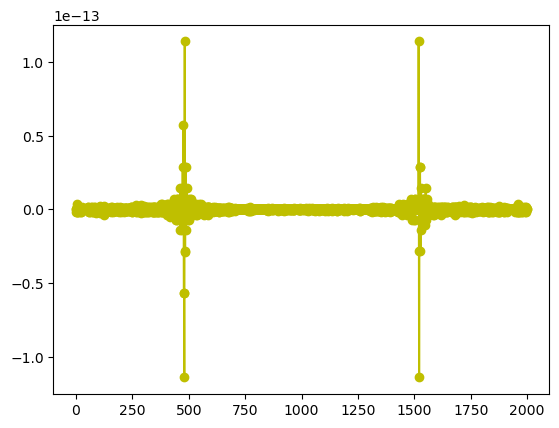

> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/mc.py(133)vmc_worker()
    131                 plt.show()
    132                 pdb.set_trace()
--> 133                 grad = - limdrift(np.real(g1.T))
    134                 gauss = np.random.normal(scale=np.sqrt(tstep), size=(nconf, 3))
    135                 newcoorde = configs.configs[:, e, :] + gauss + grad * tstep



ipdb>  exit


In [68]:
#PYQMC VMC 
#
#
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
# Jastrow optimization
for fname in ['vmc_001.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
from recipes import ABDMC, DMC, ABVMC, VMC
npartitions = 16
# with ProcessPoolExecutor(max_workers=npartitions) as client:
#     pyqmc.recipes.VMC("scf.hdf5", "vmc_001.hdf5",  verbose=False, nsteps =nsteps, tstep= tstep, nconfig=nconfig, client=client, npartitions=npartitions)

VMC("scf.hdf5", "vmc_001.hdf5",  verbose=True, nsteps =nsteps, tstep= tstep, nconfig=nconfig)    

Mean  etot ,  -2.794387116215557 +/- 0.0025451300698847864 var 0.0011760752893887377 +/- 4.296533686509148e-05
Mean  ee ,  1.0301784809098495 +/- 0.007462269011599692 var 0.0001289849529063364 +/- 7.847448538913371e-06
Mean  ei ,  -7.160661354452224 +/- 0.052468904268721514 var 0.00679563407307259 +/- 0.00028846376299077313
Mean  ke ,  3.3360957573268175 +/- 0.04610509573310662 var 0.011518197785573041 +/- 0.00046211728279206283


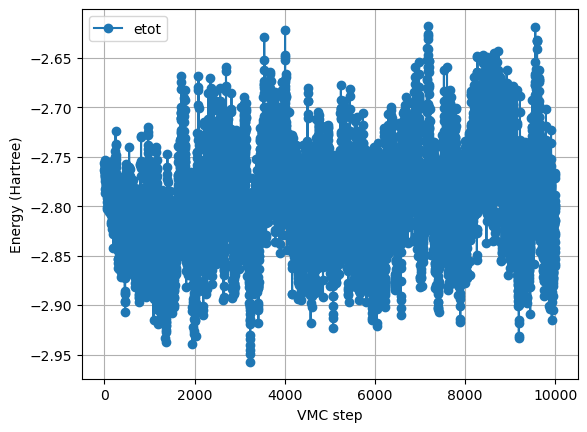

In [12]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

import matplotlib.pyplot as plt
filename = "vmc_001.hdf5"
with h5py.File(filename) as f:
    ee = f['energyee'][...]   
    ei = f['energyei'][...]
    # ii = f['energyii'][...]    
    ke = f['energyke'][...]
    etot = f['energytotal'][...]
# plt.plot(e_est, marker='o', label="E_est")
# plt.plot(e_t, marker='o', label="E_t")
plt.plot(etot, marker='o', label="etot")
# plt.plot(ee, marker='o', label="ee")
# plt.plot(ei, marker='o', label="ei")
# plt.plot(ke, marker='o', label="ke")
# plt.plot(ke+ei, marker='o', label="ke+ei")
# plt.plot(ka-ka[0], marker='o', label="ka")
# plt.plot(kb-kb[0], marker='o', label="kb")

# plt.plot(vxc-vxc[0], marker='o', label="vxc")
plt.legend()
plt.xlabel("VMC step")
plt.ylabel("Energy (Hartree)")
plt.grid()

for e in [etot, ee, ei, ke]:
    nn = namestr(e, globals())
    name = nn[0] if nn[0] != 'e' else nn[1]       
    e, e_m, e_d = reblock(e, discard,reblock_size)
    e2 = e*e
    mean = np.average(e.reshape(-1, reblock_size), axis=1)
    mean2 = np.average(e2.reshape(-1, reblock_size), axis=1)
    # var = np.mean(e**2)-np.mean(e)**2
    var = mean2-mean**2 
    var_mean  = np.mean(var, axis=0)
    var_std  = scipy.stats.sem(var, axis=0)    
    # print(mean, mean2)
    print("Mean ", name, ", ", e_m, "+/-", e_d, "var", var_mean, "+/-", var_std)

# stat_qmc(etot, filename)

In [43]:
# block_sizes = np.linspace(2,len(etot)//16, 10, dtype=int)
# reblocks = [len(etot)//s for s in block_sizes]
# print(reblocks)
# print(block_sizes)
# df = pd.DataFrame([pyq.read_mc_output("vmc.hdf5", warmup=discard, reblock=reblock) for reblock in reblocks])
# df['block_size'] = block_sizes
# plt.plot("block_size",'energytotal_err',data=df, marker='o')
# plt.xlabel("Block size")
# plt.ylabel("Estimated uncertainty (Ha)")

In [16]:
#Timestep error tests
t = [1, 0.3, 0.1, 0.01, 0.001]
e_t_vmc = []
e_t_vmc_err = []
e_dict = {}
for dt in t:
    for fname in ['vmc.hdf5']:
        if os.path.isfile(fname):
            os.remove(fname)    
    dt_steps = int(nsteps*tstep/dt)
    dt_steps = 1000 if dt_steps < 1000 else dt_steps
    dt_steps = 2000 if dt_steps > 2000 else dt_steps 
    dt_discard = int(dt_steps/2)
    print(dt, dt_steps, dt_discard)
    with ProcessPoolExecutor(max_workers=npartitions) as client:
        pyqmc.recipes.VMC("scf.hdf5", "vmc.hdf5",  verbose=False, nsteps =nsteps, tstep= tstep, nconfig=nconfig, client=client, npartitions=npartitions)
    with h5py.File("vmc.hdf5") as f:
        etot_t = f['energytotal'][...] 
    e_dict[dt]=etot_t
    for e in [etot_t]:
        e_m = np.mean(e[dt_discard:])
        e_d = np.var(e[dt_discard:])
        e_t_vmc.append(e_m)
        e_t_vmc_err.append(e_d)



1 1000 500


/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '
/Users/ksu/Software/anaconda3/lib/python3.11

0.3 1000 500


/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '
/Users/ksu/Software/anaconda3/lib/python3.11

0.1 1000 500


/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '
/Users/ksu/Software/anaconda3/lib/python3.11

0.01 1000 500


/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '
/Users/ksu/Software/anaconda3/lib/python3.11

0.001 2000 1000


/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '
/Users/ksu/Software/anaconda3/lib/python3.11

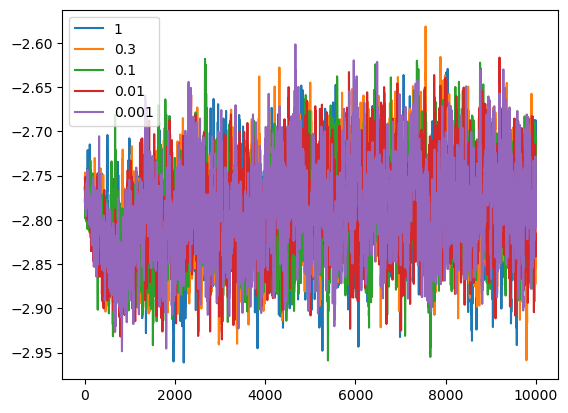

In [17]:
for i in t:
    plt.plot(e_dict[i], label=str(i))
plt.legend()

Text(0, 0.5, 'Energy (Ha)')

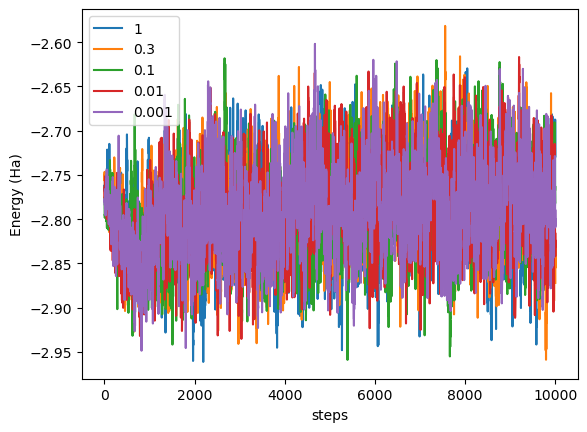

In [18]:
for i in t:
    plt.plot(e_dict[i], label=str(i))
plt.legend()
plt.xlabel('steps')
plt.ylabel('Energy (Ha)')

In [20]:
#PYQMC VMC with jastrow
#
#
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
# Jastrow optimization
for fname in ['vmc-j-001.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
from recipes import ABDMC, DMC, ABVMC, VMC
npartitions = 16
with ProcessPoolExecutor(max_workers=npartitions) as client:
    pyqmc.recipes.VMC("scf.hdf5", "vmc-j-001.hdf5",  load_parameters="sj.hdf5", verbose=True, nsteps =nsteps, tstep= tstep, nconfig=nconfig, client=client, npartitions=npartitions)

# VMC("scf.hdf5", "vmc-j-001.hdf5",  load_parameters="sj.hdf5", verbose=True, nsteps =nsteps, tstep= tstep, nconfig=nconfig)

----

/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '
/Users/ksu/Software/anaconda3/lib/python3.11

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Mean  etot_j ,  -2.8812479804213194 +/- 0.001732675456715625 var 0.00021089750668262854 +/- 6.8529167083957974e-06
Mean  ee_j ,  0.9095498866911738 +/- 0.005750088260905786 var 7.002308273006117e-05 +/- 3.3366209280491835e-06
Mean  ei_j ,  -6.4526459422086235 +/- 0.039772337573459576 var 0.004514243858683317 +/- 0.000178620864702229
Mean  ke_j ,  2.66184807509613 +/- 0.032645020479440984 var 0.0054293396777672295 +/- 0.00020554080110712976


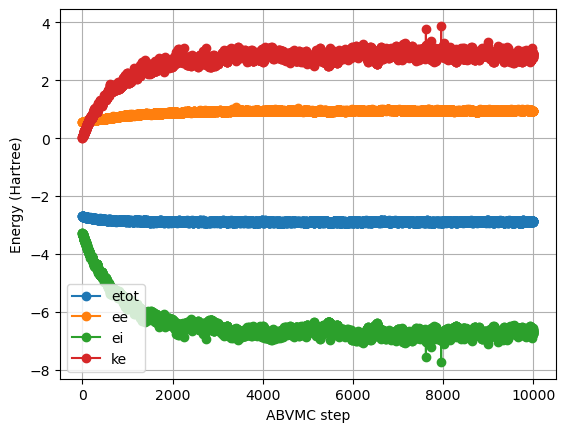

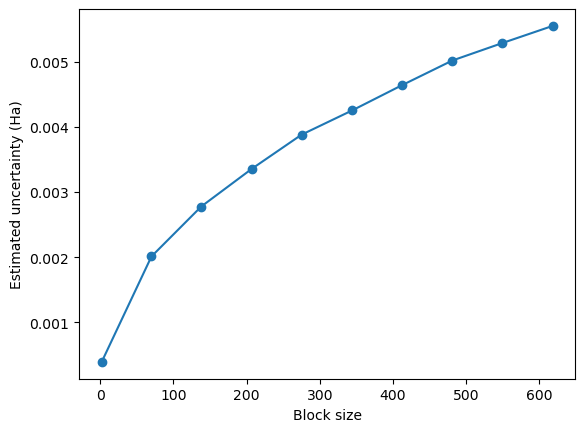

In [21]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

import matplotlib.pyplot as plt
filename="vmc-j-001.hdf5"
with h5py.File(filename) as f:
    ee_j = f['energyee'][...]   
    ei_j = f['energyei'][...]
    # ii = f['energyii'][...]    
    ke_j = f['energyke'][...]
    etot_j = f['energytotal'][...]
plt.plot(etot_j, marker='o', label="etot")
plt.plot(ee_j, marker='o', label="ee")
plt.plot(ei_j, marker='o', label="ei")
plt.plot(ke_j, marker='o', label="ke")
plt.legend()
plt.xlabel("ABVMC step")
plt.ylabel("Energy (Hartree)")
plt.grid()

for e in [etot_j, ee_j, ei_j, ke_j]:
    nn = namestr(e, globals())
    name = nn[0] if nn[0] != 'e' else nn[1]       
    e, e_m, e_d = reblock(e, discard,reblock_size)
    e2 = e*e
    mean = np.average(e.reshape(-1, reblock_size), axis=1)
    mean2 = np.average(e2.reshape(-1, reblock_size), axis=1)
    # var = np.mean(e**2)-np.mean(e)**2
    var = mean2-mean**2 
    var_mean  = np.mean(var, axis=0)
    var_std  = scipy.stats.sem(var, axis=0)    
    # print(mean, mean2)
    print("Mean ", name, ", ", e_m, "+/-", e_d, "var", var_mean, "+/-", var_std)

stat_qmc(etot_j, filename)


In [57]:
#ABVMC
#
#
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
# Jastrow optimization
for fname in ['abvmc-001.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
from recipes import ABDMC, DMC, ABVMC, VMC
tstep = 0.01
nconfig = 500
nsteps = 1000
discard = 10
reblock_size = 10
# ABDMC("scf.hdf5", "dmc.hdf5", load_parameters="sj.hdf5", ci_checkfile=ci_checkfile, accumulators = {"energy": True}, verbose=False, nsteps = 500, branchtime = 10, tstep= 0.02, nconfig=100)
# ABVMC("scf.hdf5", "dmc.hdf5", load_parameters="sj.hdf5", verbose=False, nsteps = 5000, branchtime = 5, tstep= 0.02, nconfig=500)
ABVMC("scf.hdf5", "abvmc-001.hdf5", verbose=True,  nsteps =nsteps, tstep= tstep, nconfig=nconfig)

Using spherical guess
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Mean  etot_abvmc ,  -2.8456954720224523 +/- 0.005063204496370034 var 0.0005857631675131438 +/- 5.031234903159948e-05
Mean  ee_abvmc ,  0.8958859704519079 +/- 0.011829310681128514 var 0.0005971253497567121 +/- 4.6766136982293786e-05
Mean  vh_abvmc ,  3.8142952960036585 +/- 0.028277509284862543 var 0.00047994769607898985 +/- 0.00010439199176987658
Mean  vxc_abvmc ,  -1.1856200895139046 +/- 0.012206893051515417 var 0.00010700359456620549 +/- 2.2770390278388712e-05
Mean  ecorr_abvmc ,  -1.1129062359846071 +/- 0.0 var 0.0 +/- 0.0
Mean  ei_abvmc ,  -5.9065069593227255 +/- 0.07172436708723819 var 0.02384953661997476 +/- 0.0024880517033917765
Mean  vhxc_abvmc ,  2.6286752064897536 +/- 0.01608471273622225 var 0.00013906136950709365 +/- 3.0238475522339676e-05
Mean  ii_abvmc ,  0.0 +/- 0.0 var 0.0 +/- 0.0
Mean  ke_abvmc ,  0.0 +/- 0.0 var 0.0 +/- 0.0
LDA Energy,  -2.826706554186113


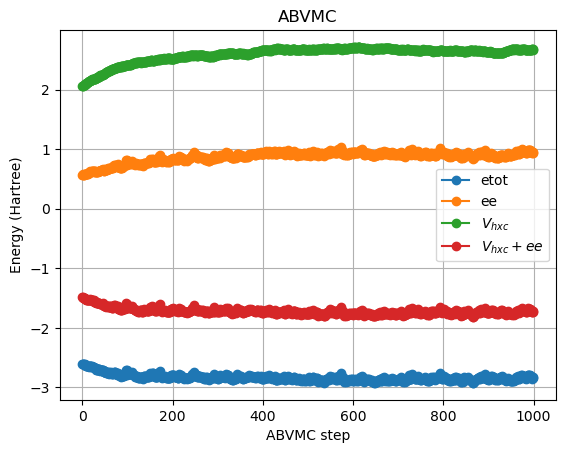

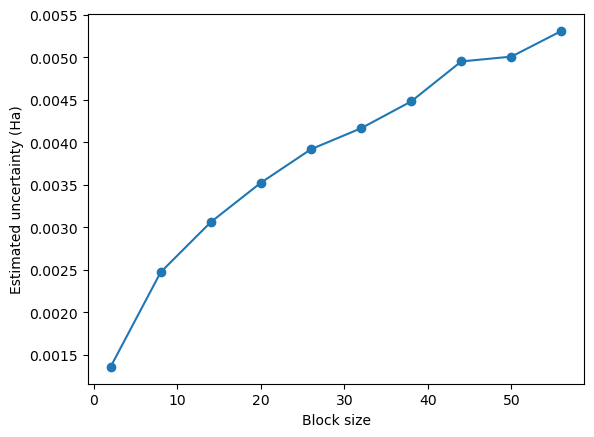

In [139]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
import matplotlib.pyplot as plt
filename="abvmc-001.hdf5"
with h5py.File(filename) as f:
    ee_abvmc = f['energyee'][...]   
    ei_abvmc = f['energyei'][...]
    vh_abvmc = f['energyvh'][...]   
    vxc_abvmc = f['energyvxc'][...]       
    # eid = f['energyeid'][...]    
    ii_abvmc = f['energyii'][...]    
    ke_abvmc = f['energyke'][...]
    ka_abvmc = f['energyka'][...]
    kb_abvmc = f['energykb'][...]   
    ecorr_abvmc = f['energycorr'][...]    
    etot_abvmc = f['energytotal'][...] 
vhxc_abvmc = vh_abvmc + vxc_abvmc
veall_abvmc = -vhxc_abvmc + ee_abvmc
# plt.plot(e_t, marker='o', label="E_t")
plt.plot(etot_abvmc, marker='o', label="etot")
# plt.plot(ii_abvmc, marker='o', label="ii")
plt.plot(ee_abvmc, marker='o', label="ee")
# plt.plot(ei_abvmc, marker='o', label="ei")
# plt.plot(ecorr_abvmc, marker='o', label="dft_eig")
plt.plot(vhxc_abvmc, marker='o', label=r"$V_{hxc}$")
plt.plot(veall_abvmc, marker='o', label=r"$V_{hxc}+ee$")
# plt.plot(vh_abvmc, marker='o', label=r"$V_{h}$")
# plt.plot(vxc_abvmc+vh_abvmc, marker='o', label=r"$V_{hxc}$")
# plt.plot(ecorr_abvmc, marker='o', label=r"$ecorr$")


# plt.plot(ke_abvmc, marker='o', label="ke")

# plt.plot(ee-eed, marker='o', label="ee-diff")
# plt.plot(ei, marker='o', label="ei")
# plt.plot(eid, marker='o', label="eid")
# plt.plot(eed, marker='o', label="eed")
# plt.plot(ei-eid, marker='o', label="ei-eid")

# eboson=ee-vxc
# plt.plot(eboson, marker='o', label="boson")
# plt.plot(ke, marker='o', label="ke")
# plt.plot(ka-ka[0], marker='o', label="ka")
# plt.plot(kb-kb[0], marker='o', label="kb")

# plt.plot(vxc-vxc[0], marker='o', label="vxc")
plt.legend()
plt.xlabel("ABVMC step")
plt.ylabel("Energy (Hartree)")
plt.grid()
plt.title('ABVMC')
for e in [etot_abvmc, ee_abvmc, vh_abvmc, vxc_abvmc, ecorr_abvmc, ei_abvmc, vhxc_abvmc, ii_abvmc,  ke_abvmc]:
    nn = namestr(e, globals())
    name = nn[0] if nn[0] != 'e' else nn[1]       
    e, e_m, e_d = reblock(e, discard,reblock_size)
    e2 = e*e
    mean = np.average(e.reshape(-1, reblock_size), axis=1)
    mean2 = np.average(e2.reshape(-1, reblock_size), axis=1)
    # var = np.mean(e**2)-np.mean(e)**2
    var = mean2-mean**2 
    var_mean  = np.mean(var, axis=0)
    var_std  = scipy.stats.sem(var, axis=0)    
    # print(mean, mean2)
    print("Mean ", name, ", ", e_m, "+/-", e_d, "var", var_mean, "+/-", var_std)
# e_m2 = np.mean(etot2[discard:])
# e_d2 = np.var(etot2[discard:])

# print("Mean VMC Energy, ", df.iloc[1].energy, "+/-", df.iloc[1].error)
print("LDA Energy, ", mf_lda.energy_tot())
# plt.plot(ed, marker='o', label="ke")

stat_qmc(etot_abvmc, filename)


In [124]:
#Timestep error tests
t = [1, 0.3, 0.1, 0.01]
e_t_abvmc = []
e_t_abvmc_err = []
ab_e_dict = {}
for dt in t:
    for fname in ['vmc.hdf5']:
        if os.path.isfile(fname):
            os.remove(fname)    
    dt_steps = int(nsteps*tstep/dt)
    dt_steps = 1000 if dt_steps < 1000 else dt_steps
    dt_steps = 2000 if dt_steps > 2000 else dt_steps 
    dt_discard = int(dt_steps/2)
    print(dt_steps, dt_discard)
    ABVMC("scf.hdf5", "vmc.hdf5", verbose=True, nsteps =dt_steps, tstep=dt, nconfig=nconfig)
    with h5py.File("vmc.hdf5") as f:
        etot_t = f['energytotal'][...] 
    ab_e_dict[dt]=etot_t
    for e in [etot_t]:
        e_m = np.mean(e[dt_discard:])
        e_d = np.var(e[dt_discard:])
        e_t_abvmc.append(e_m)
        e_t_abvmc_err.append(e_d)



1000 500
Using spherical guess
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<ErrorbarContainer object of 3 artists>

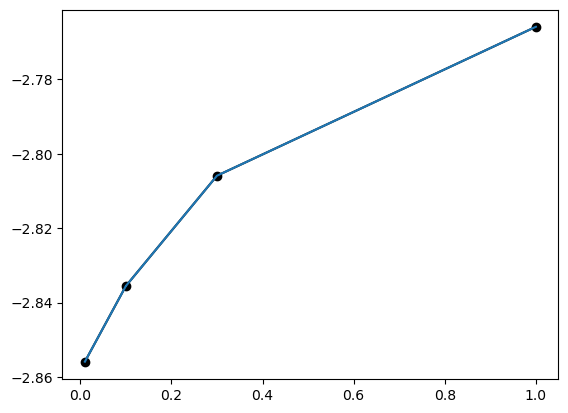

In [125]:
plt.plot(t, e_t_abvmc, '-ok')
plt.errorbar(t, e_t_abvmc, yerr = e_t_abvmc_err)

Text(0, 0.5, 'Energy (Ha)')

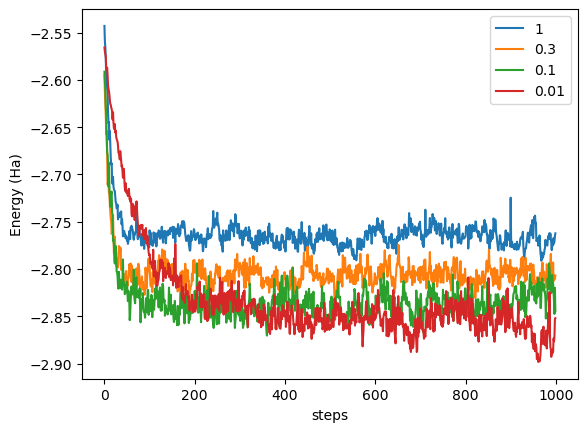

In [128]:
for i in t:
    plt.plot(ab_e_dict[i], label=str(i))
plt.legend()
plt.xlabel('steps')
plt.ylabel('Energy (Ha)')

[[[-0.1       -0.1        0.1      ]
  [-0.1        0.9        0.1      ]]

 [[-0.1       -0.1        0.1004002]
  [-0.1        0.9        0.1004002]]

 [[-0.1       -0.1        0.1008004]
  [-0.1        0.9        0.1008004]]

 ...

 [[-0.1       -0.1        0.8991996]
  [-0.1        0.9        0.8991996]]

 [[-0.1       -0.1        0.8995998]
  [-0.1        0.9        0.8995998]]

 [[-0.1       -0.1        0.9      ]
  [-0.1        0.9        0.9      ]]]
-> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/mc.py(394)abvmc_worker()
    392             import pdb
    393             pdb.set_trace()
--> 394             g1, val, _ = wf.gradient_value(e, configs.electron(e))
    395             import matplotlib.pyplot as plt
    396             # plt.plot(g1[0,:], '-or')



ipdb>  c


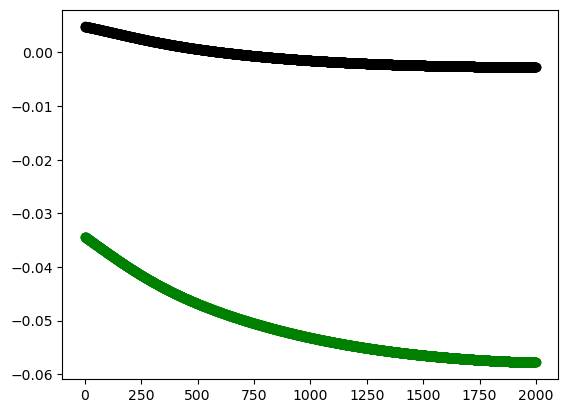

> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/mc.py(402)abvmc_worker()
    400             plt.show()
    401             pdb.set_trace()
--> 402             grad = - limdrift(np.real(g1.T))
    403             gauss = np.random.normal(scale=np.sqrt(tstep), size=(nconf, 3))
    404             newcoorde = configs.configs[:, e, :] + gauss + grad * tstep



In [ ]:
#ABVMC with jastrows
#
#
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
# Jastrow optimization
for fname in ['abvmc-j-001.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
from recipes import ABDMC, DMC, ABVMC, VMC

ABVMC("scf.hdf5", "abvmc-j-001.hdf5", verbose=True,  nsteps =nsteps, tstep= tstep, nconfig=nconfig)

Mean  etot_abvmc_j ,  -0.9984570705175752 +/- 0.004770059915376012 var 0.0012230153782566114 +/- 0.0004723545227385392
Mean  ee_abvmc_j ,  0.05018177826839009 +/- 1.5264011635011776e-05 var 5.5432908246732e-10 +/- 1.2523670200903625e-10
Mean  vh_abvmc_j ,  1.278214322834522 +/- 0.00265239105599474 var 4.070896976984508e-06 +/- 1.0907374112780804e-06
Mean  vxc_abvmc_j ,  -0.7105868005707879 +/- 0.0026659361555967623 var 4.322149245647753e-06 +/- 1.4460533009053033e-06
Mean  ecorr_abvmc_j ,  -0.5278456734326142 +/- 0.0 var -1.1102230246251565e-16 +/- 0.0
Mean  ei_abvmc_j ,  -1.9224024199675094 +/- 0.021550501270620585 var 0.0029453296214357514 +/- 0.0007572516619289637
Mean  vhxc_abvmc_j ,  0.567627522263734 +/- 0.0002267308117812014 var 2.765863763607188e-07 +/- 6.073875942280445e-08
Mean  ii_abvmc_j ,  0.049999999999999996 +/- 1.6829289700449406e-18 var 1.734723475976807e-18 +/- 0.0
LDA Energy,  -0.9556902488959487


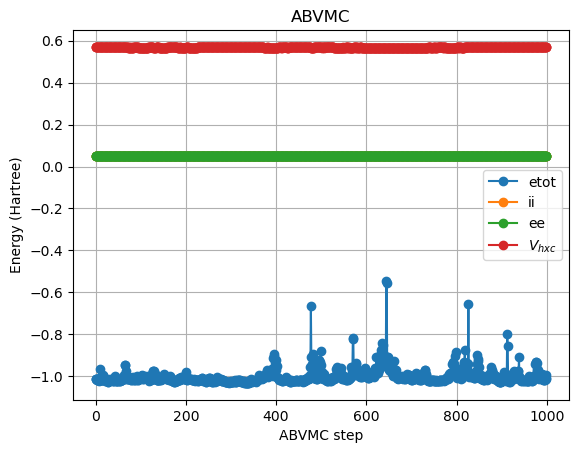

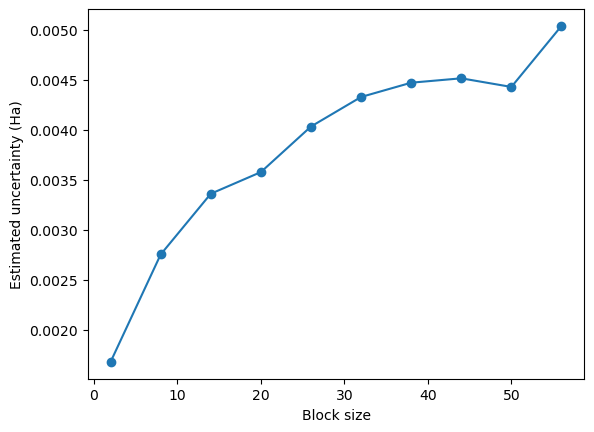

In [78]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
import matplotlib.pyplot as plt
filename="abvmc-j-001.hdf5"
with h5py.File(filename) as f:
    ee_abvmc_j = f['energyee'][...]   
    ei_abvmc_j = f['energyei'][...]
    vh_abvmc_j = f['energyvh'][...]   
    vxc_abvmc_j = f['energyvxc'][...]       
    # eid = f['energyeid'][...]    
    ii_abvmc_j = f['energyii'][...]    
    ke_abvmc_j = f['energyke'][...]
    ka_abvmc_j = f['energyka'][...]
    kb_abvmc_j = f['energykb'][...]   
    ecorr_abvmc_j = f['energycorr'][...]    
    etot_abvmc_j = f['energytotal'][...] 
vhxc_abvmc_j = vh_abvmc_j + vxc_abvmc_j
# plt.plot(e_t, marker='o', label="E_t")
plt.plot(etot_abvmc_j, marker='o', label="etot")
plt.plot(ii_abvmc_j, marker='o', label="ii")
plt.plot(ee_abvmc_j, marker='o', label="ee")
# plt.plot(ecorr_abvmc, marker='o', label="dft_eig")
# plt.plot(vxc_abvmc, marker='o', label=r"$V_{xc}$")
# plt.plot(vh_abvmc, marker='o', label=r"$V_{h}$")
plt.plot(vxc_abvmc_j+vh_abvmc_j, marker='o', label=r"$V_{hxc}$")
# plt.plot(ecorr_abvmc, marker='o', label=r"$ecorr$")


# plt.plot(ke, marker='o', label="ke")

# plt.plot(ee-eed, marker='o', label="ee-diff")
# plt.plot(ei, marker='o', label="ei")
# plt.plot(eid, marker='o', label="eid")
# plt.plot(eed, marker='o', label="eed")
# plt.plot(ei-eid, marker='o', label="ei-eid")

# eboson=ee-vxc
# plt.plot(eboson, marker='o', label="boson")
# plt.plot(ke, marker='o', label="ke")
# plt.plot(ka-ka[0], marker='o', label="ka")
# plt.plot(kb-kb[0], marker='o', label="kb")

# plt.plot(vxc-vxc[0], marker='o', label="vxc")
plt.legend()
plt.xlabel("ABVMC step")
plt.ylabel("Energy (Hartree)")
plt.grid()
plt.title('ABVMC')

for e in [etot_abvmc_j, ee_abvmc_j, vh_abvmc_j, vxc_abvmc_j, ecorr_abvmc_j, ei_abvmc_j, vhxc_abvmc_j, ii_abvmc_j]:
    nn = namestr(e, globals())
    name = nn[0] if nn[0] != 'e' else nn[1]       
    e, e_m, e_d = reblock(e, discard,reblock_size)
    e2 = e*e
    mean = np.average(e.reshape(-1, reblock_size), axis=1)
    mean2 = np.average(e2.reshape(-1, reblock_size), axis=1)
    # var = np.mean(e**2)-np.mean(e)**2
    var = mean2-mean**2 
    var_mean  = np.mean(var, axis=0)
    var_std  = scipy.stats.sem(var, axis=0)    
    # print(mean, mean2)
    print("Mean ", name, ", ", e_m, "+/-", e_d, "var", var_mean, "+/-", var_std)

# print("Mean VMC Energy, ", df.iloc[1].energy, "+/-", df.iloc[1].error)
print("LDA Energy, ", mf_lda.energy_tot())
# plt.plot(ed, marker='o', label="ke")
stat_qmc(etot_abvmc_j, filename)


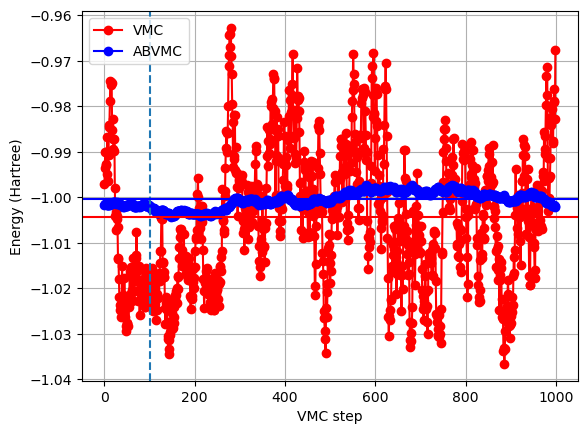

Mean  etot ,  -1.0042931949670155 +/- 0.0023967399795334103 var 0.0002125042234510932 +/- 0
Mean  etot_j ,  -1.003939629262516 +/- 0.0009614414005972414 var 5.333805198426411e-05 +/- 0
Mean  etot_abvmc ,  -1.0003981166568634 +/- 0.0004135613860595305 var 3.22723847401285e-06 +/- 0
Mean  etot_abvmc_j ,  -0.9984570705175752 +/- 0.004770059915376012 var 0.0016098243953931446 +/- 0
LDA Energy,  -0.9556902488959487


In [89]:
plt.plot(etot, marker='o', color = 'r', label="VMC")
# plt.plot(etot_j, marker='o', color = 'k', label="VMC-Jastrow")
plt.plot(etot_abvmc, marker='o', color='b', label="ABVMC")
# plt.plot(etot_abvmc_j, marker='o', color='g', label="ABVMC-Jastrow")

plt.legend()
plt.xlabel("VMC step")
plt.ylabel("Energy (Hartree)")
# plt.ylim((-1.4, -1))
plt.axvline(discard, linestyle='dashed')
plt.axhline(np.mean(etot[discard:]), color='r')
# plt.axhline(np.mean(etot_j[discard:]), color='k')
plt.axhline(np.mean(etot_abvmc[discard:]), color='b')
plt.grid()
plt.show()
for e in [etot, etot_j, etot_abvmc, etot_abvmc_j]:
    nn = namestr(e, globals())
    name = nn[0] if nn[0] != 'e' else nn[1]       
    e, e_m, e_d = reblock(e, discard,reblock_size)
    e2 = e*e
    mean = np.average(e.reshape(-1, reblock_size), axis=1)
    mean2 = np.average(e2.reshape(-1, reblock_size), axis=1)
    var = np.mean(e**2)-np.mean(e)**2
    # var = mean2-mean**2 
    # var_mean  = np.mean(var, axis=0)
    # var_std  = scipy.stats.sem(var, axis=0)    
    var_mean = var
    var_std = 0
    # print(mean, mean2)
    print("Mean ", name, ", ", e_m, "+/-", e_d, "var", var_mean, "+/-", var_std)
    
print("LDA Energy, ", mf_lda.energy_tot())

In [80]:
# #Timestep error tests
# t = [0.3, 0.1, 0.01, 0.001]
# e_t = []
# for dt in t:
#     for fname in ['vmc.hdf5', 'dmc.hdf5']:
#         if os.path.isfile(fname):
#             os.remove(fname)    
#     ABVMC("scf.hdf5", "vmc.hdf5", verbose=True, nsteps =200, tstep=dt, nconfig=200)
#     with h5py.File("vmc.hdf5") as f:
#         etot_t = f['energytotal'][...] 
#     for e in [etot_t]:
#         e_m = np.mean(e[discard:])
#         e_d = np.var(e[discard:])
#         e_t.append(e_m)



In [81]:
# plt.plot(t, e_t, '-ok')
# print(e_t[-1])